Tests integration of all three models to see if it works.

In [18]:
import os
import time

import cv2
import torch 
import numpy as np
import face_alignment
import matplotlib.pyplot as plt

import cheapfake.contrib.dataset as dataset
from cheapfake.contrib.models import CheapFake
import cheapfake.contrib.transforms as transforms
import cheapfake.contrib.video_processor as video_processor

%matplotlib notebook

In [2]:
random_seed = 3
metadata_path = "/home/shu/cheapfake/cheapfake/contrib/balanced_metadata_fs03.csv"

dfdataset = dataset.DeepFakeDataset(
    metadata_path=metadata_path, frame_transform=transforms.BatchRescale(4), sequential_audio=True,random_seed=random_seed
)
frames, audio, audio_stft = dfdataset.__getitem__(100)
frames = frames[:75]
print(frames.shape)
print(audio.shape)
print(audio_stft.shape)

torch.Size([75, 3, 270, 480])
torch.Size([48000])
torch.Size([94, 1025])


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
model = CheapFake(device=device)

In [5]:
# Plot an image with the FAN features. 
fan_output = model.face_alignment_model.get_landmarks_from_batch(frames.float().cuda())
predictions = np.asarray(fan_output).squeeze(axis=1)

In [6]:
print(predictions.shape)

(75, 68, 2)


<IPython.core.display.Javascript object>


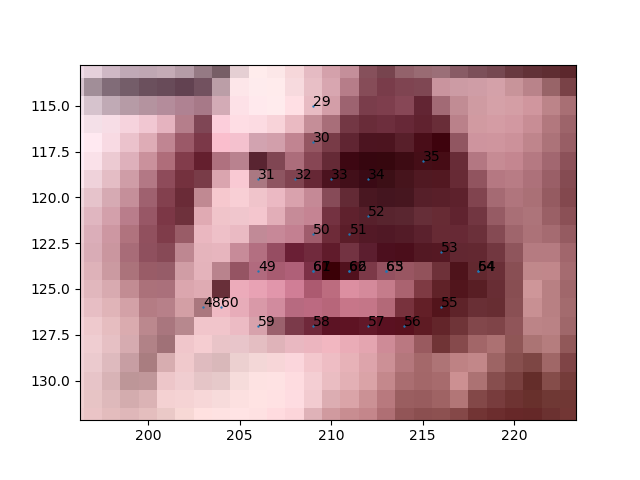

In [7]:
# Plot the predictions to see what indices are needed for the lips.
annot = list(range(0, 68))

fig, ax = plt.subplots()
ax.imshow(np.einsum("ijk->jki", frames[0]).astype("uint8"))
ax.scatter(predictions[0][:,0], predictions[0][:,1], s=0.5)

for i, txt in enumerate(annot):
    ax.annotate(txt, (predictions[0][i][0], predictions[0][i][1]))

In [69]:
def _find_bounding_box(points, tol=2):
    """Finds the minimum bounding box of the points. 
    
    """
    x_coords, y_coords = zip(*points)
    min_bbox = (min(x_coords) - tol, min(y_coords) - tol, max(x_coords) + tol, max(y_coords) + tol)
    min_bbox = tuple([int(item) for item in min_bbox])
    
    return min_bbox

In [70]:
min_bbox = _find_bounding_box(predictions[0][48:68])
print(min_bbox)

(201, 119, 220, 129)


<IPython.core.display.Javascript object>


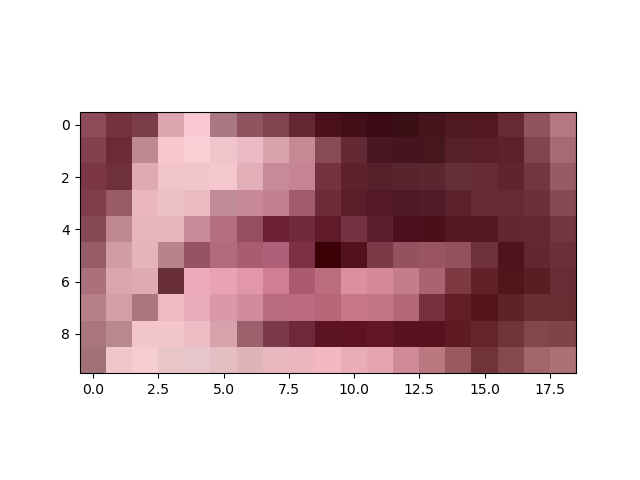

In [71]:
# Crop the image according to the minimum bbox.
cropped_image = np.einsum("ijk->jki", frames[0])[min_bbox[1]:min_bbox[3], min_bbox[0]:min_bbox[2]]
fig, ax = plt.subplots()
ax.imshow(cropped_image.astype("uint8"))

plt.show()

In [ ]:
# Reshape the cropped image to 64 x 128.
reshaped_cropped_image = cv2.resize(cropped_image, dsize=(128, 64), interpolation=cv2.INTER_CUBIC)

fig, ax = plt.subplots()
ax.imshow(reshaped_cropped_image.astype(np.int16))

In [ ]:
def _find_bounding_boxes(predictions, tol=2):
    bboxes = list()
    predictions = predictions[:,48:68]
    for prediction in predictions:
        bboxes.append(_find_bounding_box(points=prediction, tol=tol))
        
    return bboxes

In [120]:
def _crop_lips(frames, landmarks, tol=2):
    frames = np.einsum("ijkl->iklj", frames.cpu().numpy())
    bboxes = _find_bounding_boxes(predictions=landmarks, tol=tol)
    cropped_frames = torch.empty((frames.shape[0], 64, 128, frames.shape[-1]))
    for k, (bbox, frame) in enumerate(zip(bboxes, frames)):
        cropped_frame = frame[bbox[1]:bbox[3], bbox[0]:bbox[2], :]
        cropped_frames[k] = torch.from_numpy(cv2.resize(cropped_frame, dsize=(128, 64), interpolation=cv2.INTER_CUBIC))
        
    return cropped_frames

In [121]:
def _forward_fan(x):
    fan_output = model.face_alignment_model.get_landmarks_from_batch(x)
    fan_output = np.asarray(fan_output).squeeze(axis=1)
    
    cropped_frames = _crop_lips(x, fan_output)
    
    return predictions, cropped_frames

In [122]:
start_time = time.time()
predictions, cropped_frames = _forward_fan(frames.float().cuda())
end_time = time.time()

print("Entire operation took {} seconds".format(end_time - start_time))

(75, 20, 2)
Entire operation took 35.455896854400635 seconds


<IPython.core.display.Javascript object>


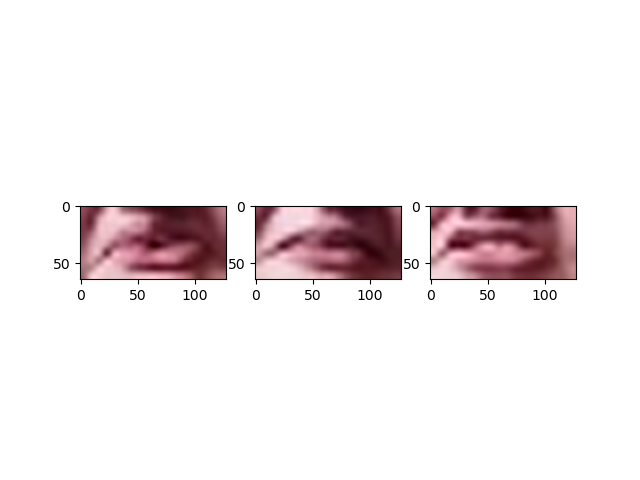

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [127]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(cropped_frames[0].cpu().numpy().astype(np.int16))
ax[1].imshow(cropped_frames[1].cpu().numpy().astype(np.int16))
ax[2].imshow(cropped_frames[2].cpu().numpy().astype(np.int16))